Overview: Simple Fit
====================

In this example, we'll fit 1D data of a `Gaussian` profile with a 1D `Gaussian` model using MCMC, nested sampling and
optimization non-linear searches.

In [1]:
%matplotlib inline

import autofit as af
import autofit.plot as aplt

import matplotlib.pyplot as plt
import numpy as np
import os
from os import path

At the top of every tutorial notebook, you'll see the following cell. This cell uses the project `pyprojroot` to
locate the path to the workspace on your computer and use it to set the working directory of the notebook.


In [2]:
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


__Data__

First, lets load data of a 1D Gaussian, by loading it from a .json file in the directory 
`autofit_workspace/dataset//gaussian_x1`.

In [3]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")

data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))

noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

Now lets plot the data, including its error bars. We'll use its shape to determine the xvalues of the data for the plot.

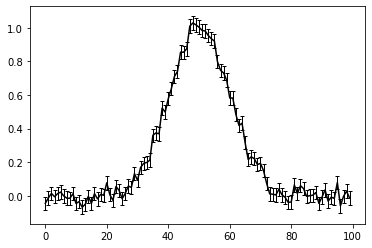

In [4]:
xvalues = range(data.shape[0])

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.show()
plt.close()

__Model__

Next, we create our model, which in this case corresponds to a single Gaussian.

We write our model component below. which has 3 parameters (centre, intensity and sigma). These are the free
parameters of our model that the non-linear search fits for, meaning the non-linear parameter space
has dimensionality = 3.

In [5]:
class Gaussian:
    def __init__(
        self,
        centre=0.0,  # <- PyAutoFit recognises these constructor arguments
        intensity=0.1,  # <- are the Gaussian`s model parameters.
        sigma=0.01,
    ):
        """Represents a 1D `Gaussian` profile, which may be treated as a model-component of PyAutoFit the
        parameters of which are fitted for by a non-linear search.

        Parameters
        ----------
        centre : float
            The x coordinate of the profile centre.
        intensity : float
            Overall intensity normalisation of the `Gaussian` profile.
        sigma : float
            The sigma value controlling the size of the Gaussian.
        """

        self.centre = centre
        self.intensity = intensity
        self.sigma = sigma

    def profile_from_xvalues(self, xvalues):
        """
        Calculate the intensity of the profile on a line of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, using its centre.

        Parameters
        ----------
        xvalues : np.ndarray
            The x coordinates in the original reference frame of the grid.
        """

        transformed_xvalues = xvalues - self.centre

        return np.multiply(
            np.divide(self.intensity, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )

We pass the class above to a `Model` to compose it as a model-component that we can fit for.

In [6]:
model = af.Model(Gaussian)

The priors for the `Gaussian` module component are loaded from the priors specified
in `autofit_workspace/config/priors`, which we can print to view.

In [7]:
print(model)

Gaussian (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, LogUniformPrior, lower_limit = 1e-06, upper_limit = 1000000.0), (sigma, UniformPrior, lower_limit = 0.0, upper_limit = 25.0)


More details on prior configs are given in the **HowToFit** tutorials.

We can manually over-ride the priors with our own as follows:

In [8]:
model.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.intensity = af.LogUniformPrior(lower_limit=1e-2, upper_limit=1e2)
model.sigma = af.GaussianPrior(
    mean=10.0, sigma=5.0, lower_limit=0.0, upper_limit=np.inf
)

print(model)

Gaussian (centre, UniformPrior, lower_limit = 0.0, upper_limit = 100.0), (intensity, LogUniformPrior, lower_limit = 0.01, upper_limit = 100.0), (sigma, GaussianPrior, mean = 10.0, sigma = 5.0)


__Analysis__

We now set up our Analysis, which describes how given an instance of our model (a Gaussian) we fit the data and
return a log likelihood value.

In [9]:
class Analysis(af.Analysis):

    """
    In this example the Analysis only contains the data and noise-map. It can be easily extended however, for more
    complex data-sets and model fitting problems.
    """

    def __init__(self, data, noise_map):

        super().__init__()

        self.data = data
        self.noise_map = noise_map

    """
    In the log_likelihood_function function below, `instance` is an instance of our model, which in this example is
    an instance of the `Gaussian` class in `model.py`. The parameters of the `Gaussian` are set via the non-linear
    search. This gives us the instance of our model we need to fit our data!
    """

    def log_likelihood_function(self, instance):
        """
        Determine the log likelihood of a fit of a `Gaussian` to the dataset, using a model instance of the Gaussian.

        Parameters
        ----------
        instance : model.Gaussian
            The `Gaussian` model instance.

        Returnsn
        -------
        fit : Fit.log_likelihood
            The log likelihood value indicating how well this model fit the dataset.
        """

        """
        The `instance` that comes into this method is an instance of the `Gaussian` class. To convince yourself of this,
        go ahead and uncomment the lines below and run the non-linear search.
        """

        # print("Gaussian Instance:")
        # print("Centre = ", instance.centre)
        # print("Intensity = ", instance.intensity)
        # print("Sigma = ", instance.sigma)

        """Get the range of x-values the data is defined on, to evaluate the model of the Gaussian."""
        xvalues = np.arange(self.data.shape[0])

        """Use these xvalues to create model data of our Gaussian."""
        model_data = instance.profile_from_xvalues(xvalues=xvalues)

        """Fit the model gaussian line data to the observed data, computing the residuals and chi-squareds."""
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        log_likelihood = -0.5 * sum(chi_squared_map)

        return log_likelihood

    def visualize(self, paths, instance, during_analysis):

        """
        During a model-fit, the `visualize` method is called throughout the non-linear search. The `instance` passed
        into the visualize method is maximum log likelihood solution obtained by the model-fit so far and it can be
        used to provide on-the-fly images showing how the model-fit is going.
        """

        xvalues = np.arange(self.data.shape[0])

        model_data = instance.profile_from_xvalues(xvalues=xvalues)

        plt.errorbar(
            x=xvalues, y=self.data, yerr=self.noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
        )
        plt.plot(xvalues, model_data, color="r")
        plt.title("Model fit to 1D Gaussian dataset.")
        plt.xlabel("x values of profile")
        plt.ylabel("Profile intensity")

        os.makedirs(paths.image_path, exist_ok=True)
        plt.savefig(path.join(paths.image_path, "model_fit.png"))
        plt.clf()

For this simple example, we only have to pass it the data and its noise-map.

In [10]:
analysis = Analysis(data=data, noise_map=noise_map)

NESTED SAMPLING
---------------

We finally choose and set up our non-linear search. we'll first fit the data with the nested sampling algorithm
Dynesty. Below, we manually specify all of the Dynesty settings, however if we omitted them the default values
found in the config file `config/non_linear/Dynesty.ini` would be used.

We also specify a `path_prefix`, so that our results go to the folder `autofit_workspace/output/overview/simple`.

For a full description of Dynesty checkout its Github and documentation webpages:

https://github.com/joshspeagle/dynesty

https://dynesty.readthedocs.io/en/latest/index.html

In [11]:
dynesty = af.DynestyStatic(
    path_prefix=path.join("overview", "simple"),
    nlive=100,
    bound="multi",
    sample="auto",
    bootstrap=None,
    enlarge=None,
    update_interval=None,
    vol_dec=0.5,
    vol_check=2.0,
    walks=25,
    facc=0.5,
    slices=5,
    fmove=0.9,
    max_move=100,
    iterations_per_update=500,
    number_of_cores=1,
)

To perform the fit with Dynesty, we pass it our model and analysis and we`re good to go!

Checkout the folder `autofit_workspace/output/dynestystatic`, where the `NonLinearSearch` results, visualization and
information can be found.

2021-05-10 09:49:16,024 - root - INFO - Existing Dynesty samples found, resuming non-linear search.
1702it [00:00, 425911.66it/s, +100 | bound: 29 | nc: 1 | ncall: 7811 | eff(%): 23.070 | loglstar:   -inf < -49.292 <    inf | logz: -63.970 +/-  0.514 | dlogz:  0.001 >  0.109]
2021-05-10 09:49:16,396 - root - INFO - 500 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 09:49:21,261 - root - INFO - 1000 Iterations: Performing update (Visualization, outputting samples, etc.).


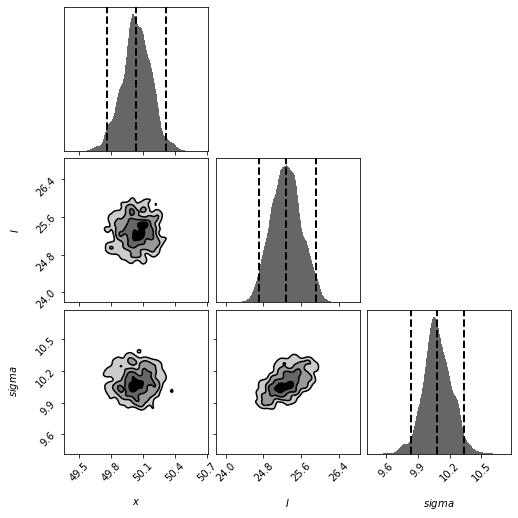

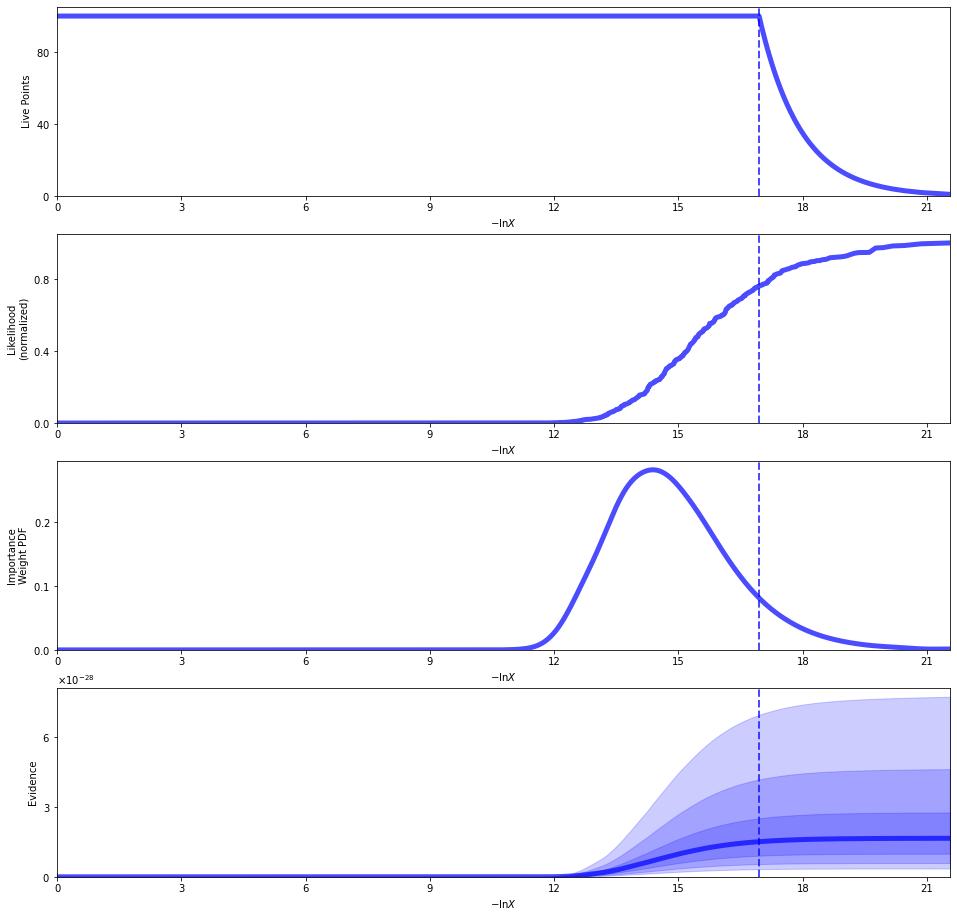

<Figure size 864x648 with 0 Axes>

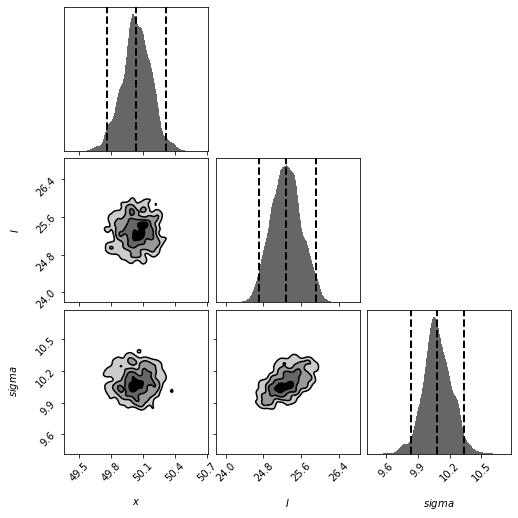

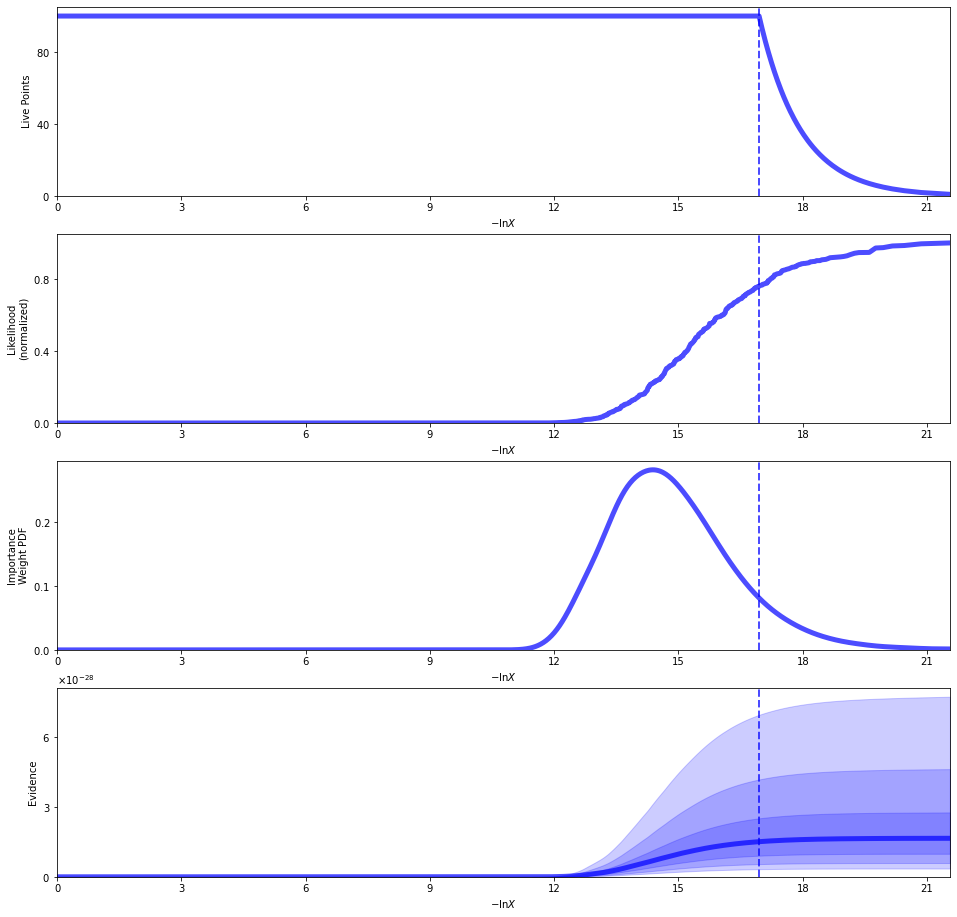

<Figure size 864x648 with 0 Axes>

In [12]:
result = dynesty.fit(model=model, analysis=analysis)

The result object returned by the fit provides information on the results of the non-linear search. Lets use it to
compare the maximum log likelihood `Gaussian` to the data.

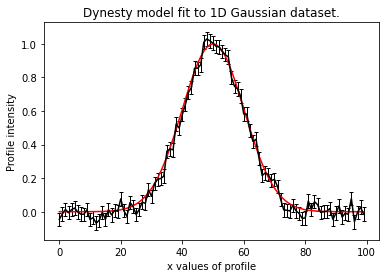

In [13]:
model_data = result.max_log_likelihood_instance.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("Dynesty model fit to 1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

The Probability Density Functions (PDF's) of the results can be plotted using Dynesty's in-built visualization tools,
which are wrapped via the `DynestyPlotter` object.

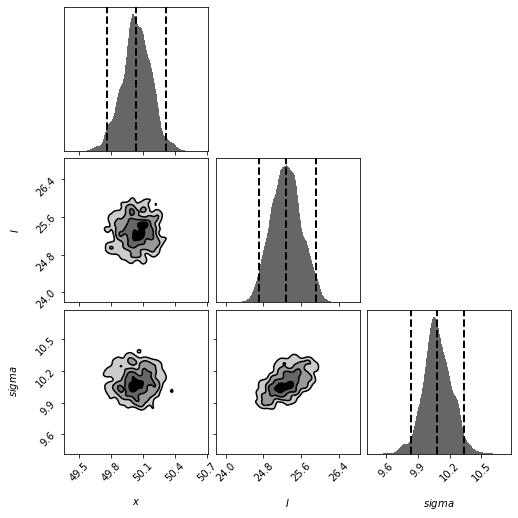

In [14]:
dynesty_plotter = aplt.DynestyPlotter(samples=result.samples)
dynesty_plotter.cornerplot()

We discuss in more detail how to use a results object in the files `autofit_workspace/example/simple/result.py`.

MCMC
----

To use a different non-linear we simply use call a different search from PyAutoFit, passing it the same the model
and analysis as we did before to perform the fit. Below, we fit the same dataset using the MCMC sampler Emcee.
Again, we manually specify all of the Emcee settings, however if they were omitted the values found in the config
file `config/non_linear/Emcee.ini` would be used instead.

For a full description of Emcee, checkout its Github and readthedocs webpages:

https://github.com/dfm/emcee
https://emcee.readthedocs.io/en/stable/

**PyAutoFit** extends **emcee** by providing an option to check the auto-correlation length of the samples
during the run and terminating sampling early if these meet a specified threshold. See this page
(https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr) for a description of how this is implemented.

2021-05-10 09:49:33,007 - root - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2021-05-10 09:49:33,016 - root - INFO - No Emcee samples found, beginning new non-linear search.
100%|██████████| 500/500 [00:06<00:00, 80.64it/s]
2021-05-10 09:49:39,238 - root - INFO - 500 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 09:49:40,241 - root - WARNING - Too few points to create valid contours
2021-05-10 09:49:40,270 - root - WARNING - Too few points to create valid contours
2021-05-10 09:49:40,290 - root - WARNING - Too few points to create valid contours
100%|██████████| 500/500 [00:06<00:00, 79.75it/s]
2021-05-10 09:49:49,034 - root - INFO - 1000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 09:49:50,668 - root - WARNING - Too few points to create valid contours
2021-05-10 09:49:50,698 - root - WARNING - Too few points to create valid contours
2021-05-10 09:49:50

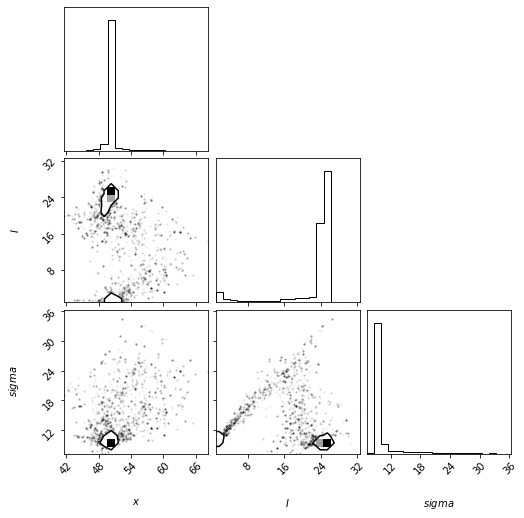

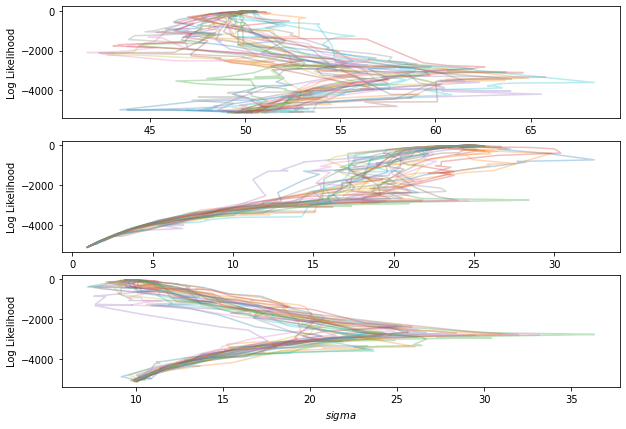

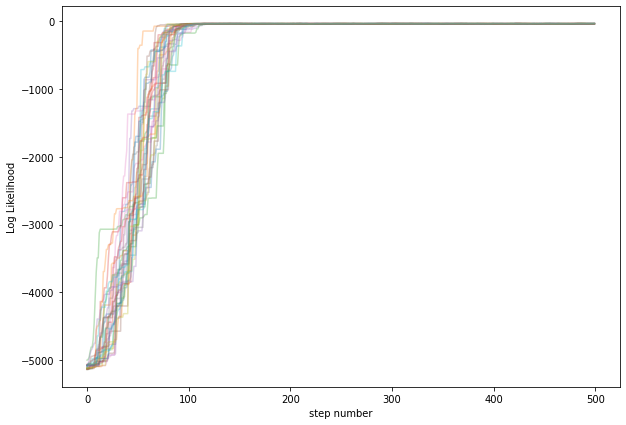

<Figure size 720x504 with 0 Axes>

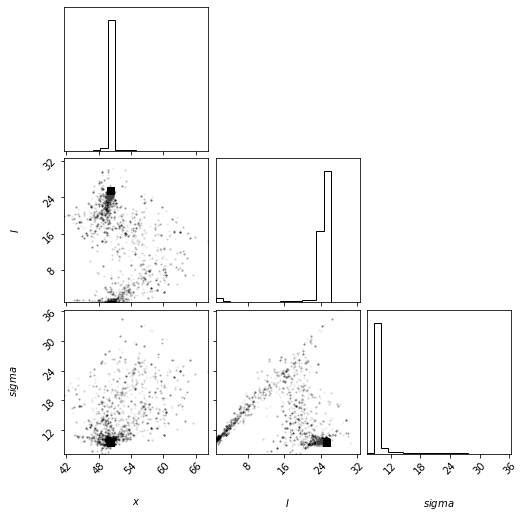

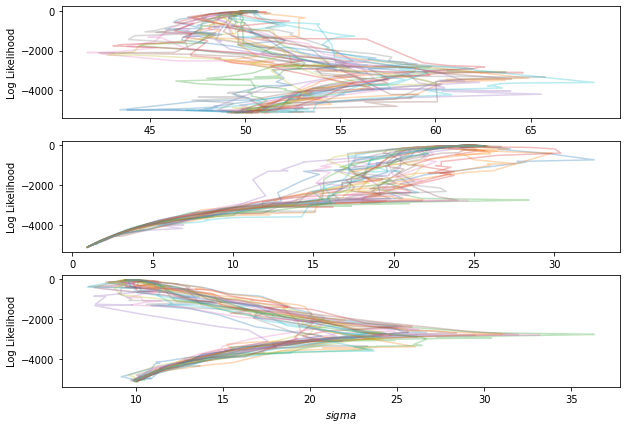

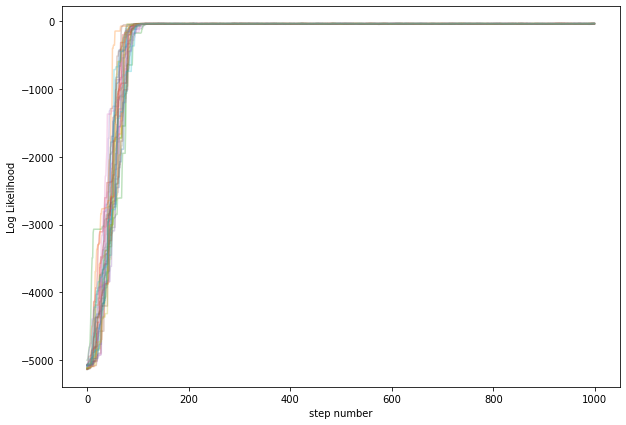

<Figure size 720x504 with 0 Axes>

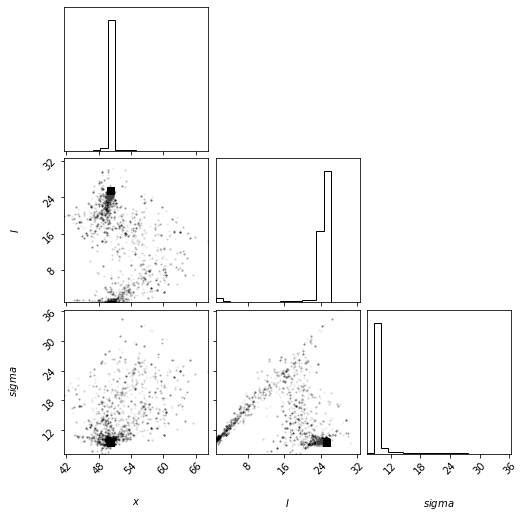

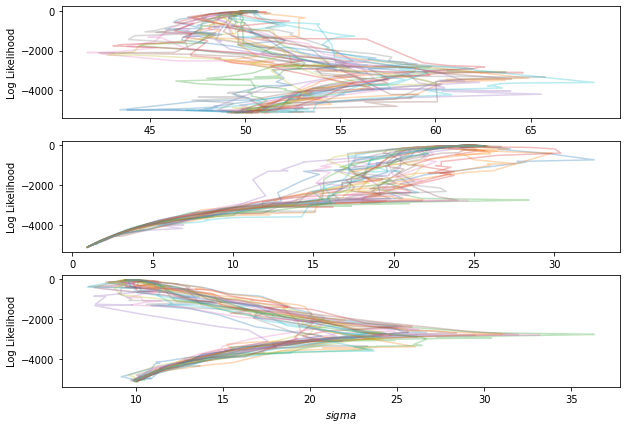

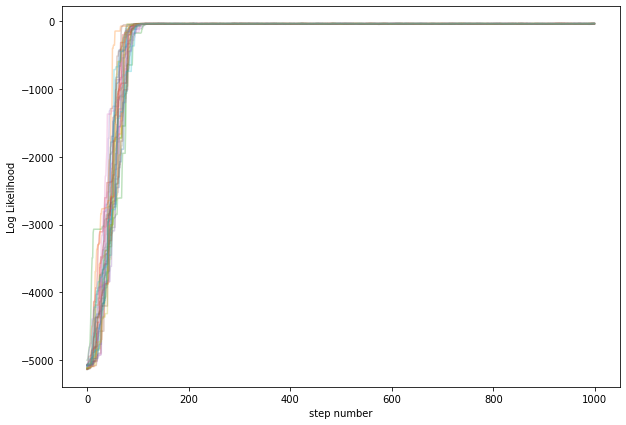

<Figure size 720x504 with 0 Axes>

In [15]:
emcee = af.Emcee(
    path_prefix=path.join("overview", "simple"),
    nwalkers=30,
    nsteps=1000,
    initializer=af.InitializerBall(lower_limit=0.49, upper_limit=0.51),
    auto_correlation_check_for_convergence=True,
    auto_correlation_check_size=100,
    auto_correlation_required_length=50,
    auto_correlation_change_threshold=0.01,
    iterations_per_update=500,
    number_of_cores=1,
)

result = emcee.fit(model=model, analysis=analysis)

The result object returned by Emcee`s fit is similar in structure to the Dynesty result above, it again provides
us with the maximum log likelihood instance.

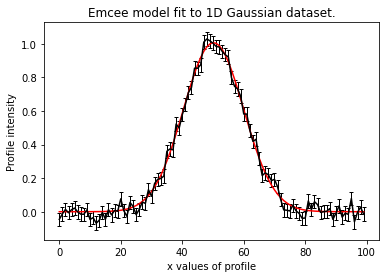

In [16]:
model_data = result.max_log_likelihood_instance.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("Emcee model fit to 1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

The Probability Density Functions (PDF's) of the results can be plotted using the Emcee's visualization
tool `corner.py`, which is wrapped via the `EmceePlotter` object.

2021-05-10 09:50:01,460 - root - WARNING - Too few points to create valid contours
2021-05-10 09:50:01,490 - root - WARNING - Too few points to create valid contours
2021-05-10 09:50:01,511 - root - WARNING - Too few points to create valid contours


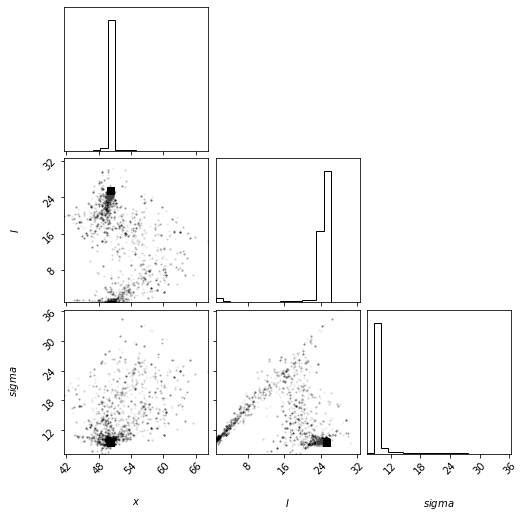

In [17]:
emcee_plotter = aplt.EmceePlotter(samples=result.samples)
emcee_plotter.corner()

Optimizer
---------

**PyAutoFit** also supports optimizer searches, which aim to find the global (or local) maxima likelihood solution.
Unlike nested samplers and MCMC algorithms, they do not extensively map out parameter space. This means they can find
the best solution a lot faster than these algorithms, but they do not properly quantify the errors on each parameter.

we'll use the Particle Swarm Optimization algorithm PySwarms. For a full description of PySwarms, checkout its Github 
and readthedocs webpages:

https://github.com/ljvmiranda921/pyswarms
https://pyswarms.readthedocs.io/en/latest/index.html

**PyAutoFit** extends *PySwarms* by allowing runs to be terminated and resumed from the point of termination, as well
as providing different options for the initial distribution of particles.

2021-05-10 09:50:01,987 - root - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2021-05-10 09:50:02,002 - root - INFO - No PySwarms samples found, beginning new non-linear search. 
2021-05-10 09:50:02,003 - root - INFO - Running PySwarmsGlobal Optimizer...
2021-05-10 09:50:02,009 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=70.4
2021-05-10 09:50:02,905 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 70.41127949628186, best pos: [50.18215316 24.69552982  9.78386658]
2021-05-10 09:50:02,918 - root - INFO - 500 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 09:50:04,312 - root - INFO - PySwarmsGlobal complete
2021-05-10 09:50:04,314 - root - INFO - 1000 Iterations: Performing update (Visualization, outputting samples, etc.).


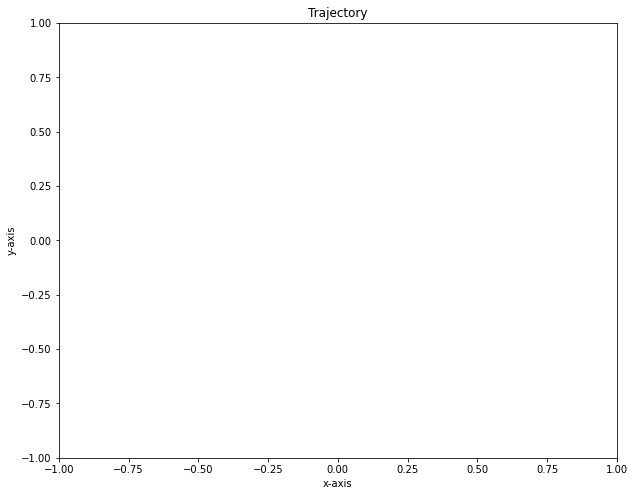

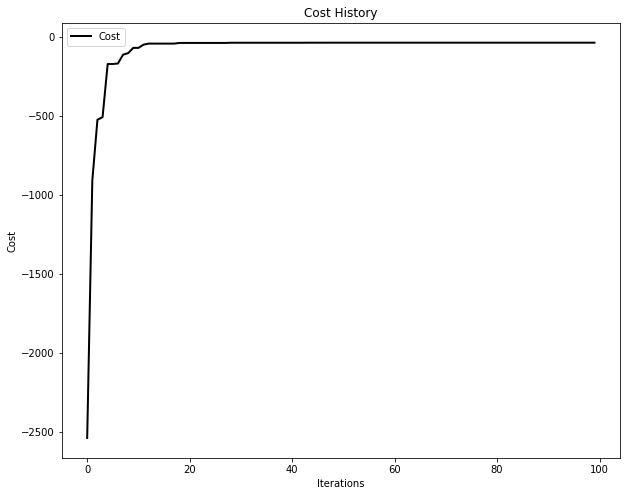

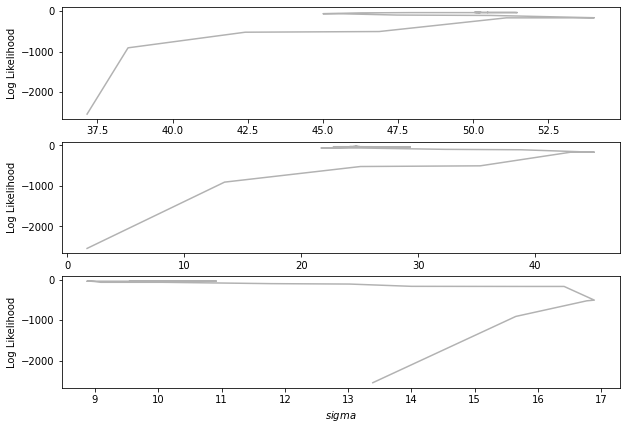

<Figure size 720x504 with 0 Axes>

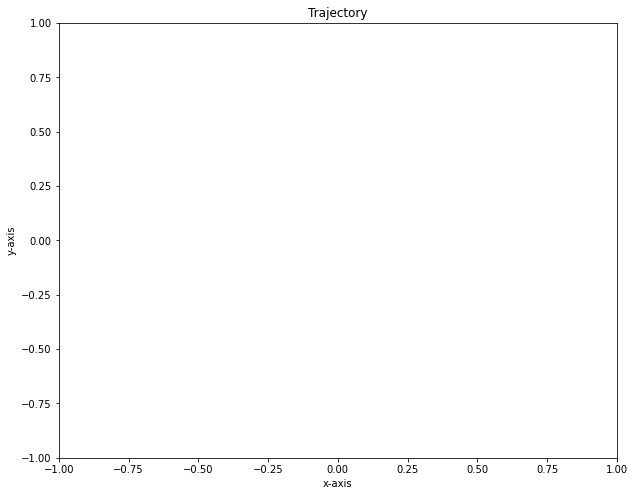

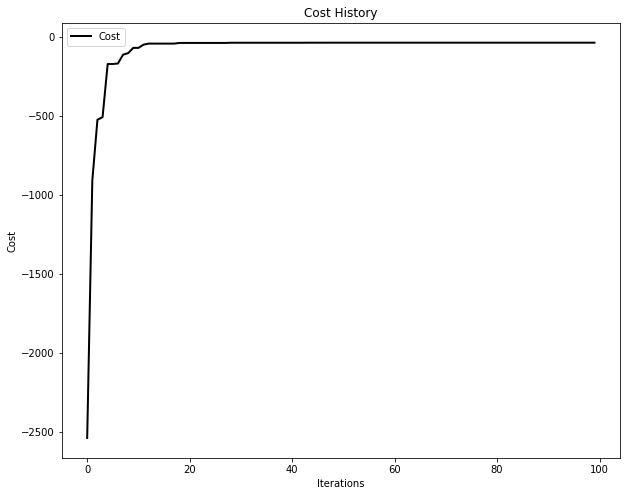

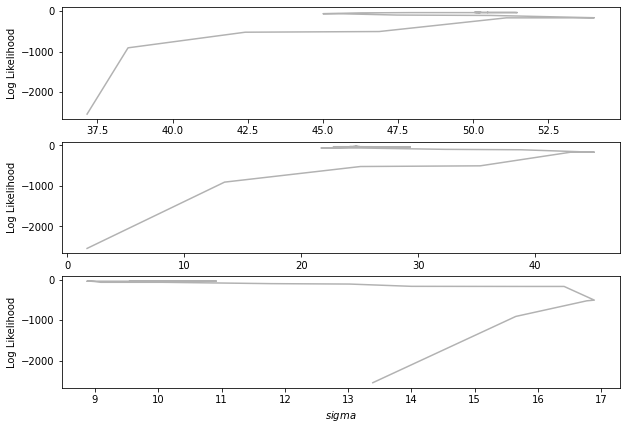

<Figure size 720x504 with 0 Axes>

In [18]:
pso = af.PySwarmsGlobal(
    path_prefix=path.join("overview", "simple"),
    n_particles=50,
    iters=100,
    cognitive=0.5,
    social=0.3,
    inertia=0.9,
    ftol=-np.inf,
    initializer=af.InitializerPrior(),
    number_of_cores=1,
)

result = pso.fit(model=model, analysis=analysis)

The result object returned by PSO is again very similar in structure to previous results.

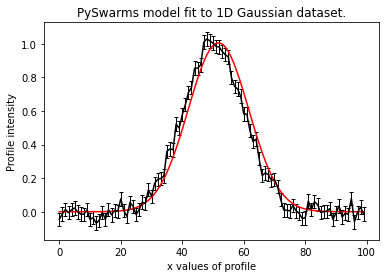

In [19]:
model_data = result.max_log_likelihood_instance.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("PySwarms model fit to 1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

The results can be plotted using the PySwarm's in-built visualization tools which are wrapped via
the `PySwarmsPlotter` object.

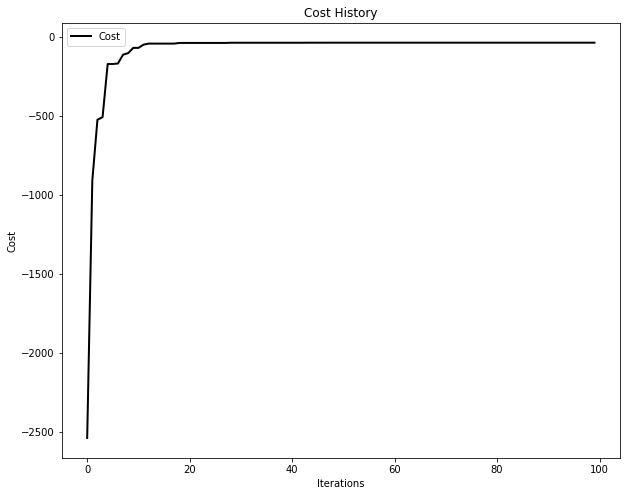

In [20]:
pyswarms_plotter = aplt.PySwarmsPlotter(samples=result.samples)
pyswarms_plotter.cost_history()

__Other Searches__

Checkout https://pyautofit.readthedocs.io/en/latest for the non-linear searches available in **PyAutoFit**.

